# Read and data cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# from utils.disease_name_mapping import dict_disease_name_mapping
# import utils.disease_name_mapping as dnm
# print(dir(dnm))
### READ DATA ###

df_raw = pd.read_csv('data/TCDCIntlEpidAll.csv')
country_mapping = pd.read_excel('data/03ËºîÂä©Áî®Ë°®_Áõ£Ê∏¨ÂúãÂÆ∂Ê∏ÖÂñÆ.xlsx')


### DATA CLEANING ###

df_raw["date"] = pd.to_datetime(df_raw['effective']).dt.date
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')

df_raw[['headline_country', 'headline_disease']] = df_raw['headline'].str.split(r'[-Ôºç‚îÄ]', n=1, expand=True) 
    # either half-width - or full-width Ôºç or Box-drawing dash ‚îÄ
df_raw['headline_country'] = df_raw['headline_country'].str.strip()
df_raw['headline_disease'] = df_raw['headline_disease'].str.strip()

df_raw = df_raw.drop(
    ["sent", "effective", "source", "expires", "senderName", "instruction", "web", "alert_title", "severity_level", "circle", "headline"], axis=1)

print(df_raw.head(2))

#disease name frequency
table_disease_freq = df_raw['headline_disease'].value_counts()
# print(table_disease_freq.head(5))

table_alert_disease_freq = df_raw['alert_disease'].value_counts() # alert disease is the original cell for the disease names which require lawful reporting
# print(table_alert_disease_freq.head(5))


                                         description   alert_disease  \
0  ÂÖ®ÁêÉÂ∞èÂÖíÈ∫ªÁó∫Ê†πÈô§ÂÄ°Ë≠∞ÁµÑÁπî(GPEI)ÂÖ¨Â∏ÉÊñº5/8-14ÊúüÈñìÔºåcVDPV2ÂûãÊñ∞Â¢û4ÂúãÂÖ±9‰æãÔºåÂàÜ...  Â∞èÂÖíÈ∫ªÁó∫Áóá/ÊÄ•ÊÄßÁÑ°ÂäõËÇ¢È´îÈ∫ªÁó∫   
1  ÁæéÂúãÊñº5/19Á¥ØË®à15Â∑ûÂ†±Âëä26‰æãÁóÖ‰æãÔºåÂÖ∂‰∏≠9‰æã‰ΩèÈô¢ÔºåÁ∂ìË™øÊü•ÁñëÊÑüÊüìÊ∫êÁÇ∫ÁîüÁî¢Ëá™‰ΩõÁæÖÈáåÈÅîÂ∑ûÊüêÂª†ÂïÜ...         Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá   

                                areaDesc  \
0  ÈòøÁàæÂèäÂà©‰∫û,Â∏ÉÂêâÁ¥çÊ≥ïÁ¥¢,Êü•Âæ∑,Ë±°ÁâôÊµ∑Â≤∏,Ë°£Á¥¢ÊØî‰∫û,Â∑¥Âü∫ÊñØÂù¶,Á¥¢È¶¨Âà©‰∫û,Ëòá‰∏π   
1                                     ÁæéÂúã   

                                         areaDesc_EN                  ISO3166  \
0  Algeria,Burkina Faso,Chad,Cote d'Ivoire,Ethiop...  DZ,BF,TD,CI,ET,PK,SO,SD   
1                                                USA                       US   

  areaDetail ISO3166_2       date headline_country headline_disease  
0        NaN       NaN 2025-05-23               ÂÖ®ÁêÉ            Â∞èÂÖíÈ∫ªÁó∫Áóá  
1        NaN       NaN

### Country names mapping

In [2]:
#####
# (1) Build a mapping using 03ËºîÂä©Áî®Ë°®_Áõ£Ê∏¨ÂúãÂÆ∂Ê∏ÖÂñÆ.xlsx: each variation matches one ISO3
#####
variation_to_iso3 = {}

for idx, row in country_mapping.iterrows():
    iso3 = row['ISO3166-1‰∏â‰Ωç‰ª£Á¢º']
    if pd.isna(iso3):
        continue  # skip entries without ISO3

    variations = set() # Collect variations from different columns

    if pd.notna(row['Áõ£Ê∏¨ÂúãÂÆ∂/ÂçÄÂüü']):
        variations.add(str(row['Áõ£Ê∏¨ÂúãÂÆ∂/ÂçÄÂüü']).strip())
    if 'ISO3166-1(‰∏≠Êñá)' in row and pd.notna(row['ISO3166-1(‰∏≠Êñá)']):
        variations.add(str(row['ISO3166-1(‰∏≠Êñá)']).strip())
    if 'Â§ñÁ∂≤ÂúãÂÆ∂Âà•' in row and pd.notna(row['Â§ñÁ∂≤ÂúãÂÆ∂Âà•']):
        variations.add(str(row['Â§ñÁ∂≤ÂúãÂÆ∂Âà•']).strip())
    if '‰∏≠ÊñáÂà•Á®±' in row and pd.notna(row['‰∏≠ÊñáÂà•Á®±']):
        aliases = str(row['‰∏≠ÊñáÂà•Á®±']).split('|') # split by '|'
        variations.update([alias.strip() for alias in aliases])

    for var in variations:
        variation_to_iso3[var] = iso3

print(list(variation_to_iso3.items())[:20]) # items is dictionary method that returns a view object containing key-value pairs as tuples.

# Sort mapping by length of variation (descending): Longest variations are checked first, which can prevent confusion such as È¶¨Âà© in Á¥¢È¶¨Âà©‰∫û
sorted_mapping = sorted(
    variation_to_iso3.items(),  # your dictionary of variation ‚ûî ISO3
    key=lambda x: len(x[0]),    # sort by length of variation string
    reverse=True                # longest first
)

# After extracting a matched variation, remove it from the text to "avoid re-matching shorter substrings" within it.
def extract_country_iso3_from_description(text, sorted_mapping):
    found_iso3 = set()  #Automatically remove duplicates if the same country is mentioned multiple times.
    if not isinstance(text, str):
        return None
    
    text_remaining = text
    for var, iso3 in sorted_mapping:
        if var in text_remaining:
            found_iso3.add(iso3)
            text_remaining = text_remaining.replace(var, '')# !  # Remove the matched variation from text_remaining to prevent further substring matches

    return list(found_iso3) if found_iso3 else None

# After extracting a matched variation, remove it from the text to "avoid re-matching shorter substrings" within it.
def extract_country_iso3_from_description(text, sorted_mapping):
    found_iso3 = set()#Automatically remove duplicates if the same country is mentioned multiple times.
    if not isinstance(text, str):
        return None

    text_remaining = text

    # Regex pattern to detect "CountryA ÂÖ¨Â∏É CountryB", where the exclusion condition applies (Country A ‚â† Country B)
    pattern_pub = re.compile(r'(\S+?)ÂÖ¨Â∏É(\S+)')
    match = pattern_pub.search(text_remaining)

    excluded_country = None
    included_country = None
    if match:
        excluded_country = match.group(1).strip() 
        included_country = match.group(2).strip() 

    for var, iso3 in sorted_mapping:
        if var in text_remaining:
            if excluded_country and included_country and var == excluded_country and var != included_country:
                continue 

            found_iso3.add(iso3)
            text_remaining = text_remaining.replace(var, '')#!Remove the matched variation from text_remaining to prevent further substring matches

    return list(found_iso3) if found_iso3 else None

df_raw['description_iso3'] = df_raw['description'].apply(
    lambda x: extract_country_iso3_from_description(x, sorted_mapping))



#####
# (2) Screening the two-value code from ISO3166 to avoid loss of extration
#####

# transform iso2 to iso3
iso2_to_iso3 = {}
for idx, row in country_mapping.iterrows():
    iso2 = row['ISO3166-1‰∫å‰Ωç‰ª£Á¢º']
    iso3 = row['ISO3166-1‰∏â‰Ωç‰ª£Á¢º']
    if pd.notna(iso2) and pd.notna(iso3):
        iso2_to_iso3[str(iso2).strip()] = str(iso3).strip()

def convert_iso2_to_iso3(iso2_str, mapping_dict):
    if pd.isna(iso2_str):
        return None
    
    iso2_str = str(iso2_str).strip()
    
    iso2_list = [code.strip() for code in iso2_str.split(',')]# Split if multiple codes
    
    iso3_list = [mapping_dict.get(code) for code in iso2_list if mapping_dict.get(code)]
    
    return iso3_list if iso3_list else None

df_raw['ISO3166_to_3code'] = df_raw['ISO3166'].apply(lambda x: convert_iso2_to_iso3(x, iso2_to_iso3))

###
# (3) screening country names from headline
### 
headline_cn_to_iso3 = {}

for idx, row in country_mapping.iterrows():
    iso3 = row['ISO3166-1‰∏â‰Ωç‰ª£Á¢º']
    if pd.isna(iso3):
        continue
    # ÂÖ®ÁêÉ/ÁæéÊ¥≤/Ê≠êÊ¥≤ will be None due to lack of iso3 code
    if pd.notna(row['‰∏≠ÊñáÂà•Á®±']):
        aliases = [alias.strip() for alias in str(row['‰∏≠ÊñáÂà•Á®±']).split('|')]
        for alias in aliases:
            headline_cn_to_iso3[alias] = iso3

def map_headline_country_to_iso3(headline_country_str, mapping_dict):
    if pd.isna(headline_country_str):
        return None
    countries = [c.strip() for c in str(headline_country_str).split('/')] #Splits the string by / to get individual countries.
    iso3_list = [mapping_dict.get(c) for c in countries if mapping_dict.get(c)]
    return iso3_list if iso3_list else None

df_raw['headline_country_iso3'] = df_raw['headline_country'].apply(
    lambda x: map_headline_country_to_iso3(x, headline_cn_to_iso3) )

###
# (4) create consolidated country_iso3 by set (description_iso3 and ISO3166_to_3code and headline_country_iso3 )
###
def combine_iso_codes(iso2_3code, description, headline):
    combined_set = set()    
    if isinstance(iso2_3code, list):
        combined_set.update(iso2_3code)
    elif pd.notna(iso2_3code): 
        combined_set.add(iso2_3code)
    
    if isinstance(description, list):
        combined_set.update(description)
    
    if isinstance(headline, list):
        combined_set.update(headline)
    
    return list(combined_set) if combined_set else None

df_raw['country_iso3'] = df_raw.apply(
    lambda row: combine_iso_codes(row['ISO3166_to_3code'], 
                                  row['description_iso3'],
                                  row['headline_country_iso3']),
    axis=1
)

print(df_raw[['ISO3166','ISO3166_to_3code', 'description_iso3', 'headline_country_iso3','country_iso3']].head(10))


[('ÂçóÊ•µÊ¥≤', 'ATA'), ('ÈòøÂØåÊ±ó', 'AFG'), ('ÈòøÁàæÂ∑¥Â∞º‰∫û', 'ALB'), ('ÈòøÁàæÂèäÂà©‰∫û', 'DZA'), ('ÁæéÂ±¨Ëñ©Êë©‰∫û', 'ASM'), ('ÁæéÂ±¨Ëñ©Êë©‰∫û(ÁæéÂ±¨)', 'ASM'), ('ÂÆâÈÅìÁàæ', 'AND'), ('ÂÆâÂì•Êãâ', 'AGO'), ('ÂÆâÂêâÊãâ(Ëã±Â±¨)', 'AIA'), ('ÂÆâÂêâÊãâ', 'AIA'), ('ÂÆâÂêâÊãâ(Ëã±ÂúãÊµ∑Â§ñÈ†òÂú∞)', 'AIA'), ('ÂÆâÂú∞Âç°ÂèäÂ∑¥Â∏ÉÈÅî', 'ATG'), ('ÈòøÊ†πÂª∑', 'ARG'), ('‰∫ûÁæéÂ∞º‰∫û', 'ARM'), ('ÈòøÈ≠ØÂ∑¥(Ëç∑Â±¨)', 'ABW'), ('ÈòøÈ≠ØÂ∑¥', 'ABW'), ('Ëç∑Â±¨ÈòøÈ≠ØÂ∑¥', 'ABW'), ('Êæ≥Ê¥≤', 'AUS'), ('Êæ≥Â§ßÂà©‰∫û', 'AUS'), ('Â•ßÂú∞Âà©', 'AUT')]
                   ISO3166                          ISO3166_to_3code  \
0  DZ,BF,TD,CI,ET,PK,SO,SD  [DZA, BFA, TCD, CIV, ETH, PAK, SOM, SDN]   
1                       US                                     [USA]   
2           CN,HK,JP,KR,SG                 [CHN, HKG, JPN, KOR, SGP]   
3                       IN                                     [IND]   
4                    BO,US                                [BOL, USA]   
5                       JP            

In [3]:
# Checks for substring confusion only between different ISO3 codes,

# confusion_list = []

# # Build a list of all variations with their ISO3 code
# variation_iso3_pairs = []

# for idx, row in country_mapping.iterrows():
#     iso3 = row['ISO3166-1‰∏â‰Ωç‰ª£Á¢º']
#     if pd.isna(iso3):
#         continue

#     # Process ‰∏≠ÊñáÂà•Á®± column
#     if pd.notna(row['‰∏≠ÊñáÂà•Á®±']):
#         aliases = [alias.strip() for alias in str(row['‰∏≠ÊñáÂà•Á®±']).split('|')]
#         for alias in aliases:
#             variation_iso3_pairs.append( (alias, iso3) )

# # Check for substring confusion among ‰∏≠ÊñáÂà•Á®± variations across different ISO3 codes
# for i, (var1, iso3_1) in enumerate(variation_iso3_pairs):
#     for j, (var2, iso3_2) in enumerate(variation_iso3_pairs):
#         if (
#             i != j 
#             and iso3_1 != iso3_2  # Only between different ISO3 codes
#             and var1 in var2
#         ):
#             confusion_list.append( (var1, var2, iso3_1, iso3_2) )

# # Display potential confusion pairs
# for c in confusion_list:
#     print(f"Alias '{c[0]}' (ISO3: {c[2]}) is substring of '{c[1]}' (ISO3: {c[3]})")


In [4]:
# assess difference 
df_diff = df_raw[
    df_raw.apply(
        lambda row: set(row['ISO3166_to_3code'] or []) != set(row['description_iso3'] or []),
        axis=1
    )
]

# Display result
print(df_diff[['description','ISO3166_to_3code', 'description_iso3', 'country_iso3']].head(10))

# there is all NA
# df_na = df_diff[df_diff['country_iso3'].isna()]
# print(df_na[['description', 'ISO3166_to_3code', 'description_iso3', 'country_iso3']].head(10))


                                          description  \
9     \rÁçÖÂ≠êÂ±±Áñ´ÊÉÖÊåÅÁ∫å‰∏äÂçáÔºåËá™5/9-16ÂñÆÈÄ±Êñ∞Â¢û611‰æãÁóÖ‰æãÔºåÈ´òÊñºÂâç1ÈÄ±483‰æãÔºåÁÇ∫IIb...   
12  ‰∏≠ÂçóÁæéÊ¥≤ËøëÂπ¥ÁóÖ‰æãÊï∏‰∏äÂçáÔºåÂ∑¥ÊãøÈ¶¨/Âì•ÊñØÂ§ßÈªéÂä†/Âä†ÊãâÁìú/ÂÆèÈÉΩÊãâÊñØ/ÁìúÂú∞È¶¨Êãâ/Ëñ©ÁàæÁì¶Â§ö/Â¢®Ë•øÂì•Á≠âÂúã...   
13  Ê≥ïÂ±¨È¶¨Á¥ÑÁâπÂ≥∂Áñ´ÊÉÖ‰∏äÂçáÔºåËá™3/5ÊñºË©≤Â≥∂Êù±ÂåóÈÉ®ÁôºÁèæÈ¶ñ‰æãËº∏ÂÖ•ÁóÖ‰æãÂæåÔºåÊà™Ëá≥5/4Á¥ØË®àÂ†±Âëä116‰æãÁóÖ‰æã...   
16  Êç∑ÂÖã5/16Â†±Âëä1‰æãÁóÖ‰æãÔºåÁñë‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüìÁóá/È¶¨Â†°ÁóÖÊØíÂá∫Ë°ÄÁÜ±ÔºåÁóÖÊÇ£ÁÇ∫41Ê≠≤ÁæéÂúãÁ±çÁî∑ÊÄßÂÄãÊ°àÔºåËøë...   
17  Êú¨ÈÄ±ÊëòË¶ÅÔºö  \r‰∫∫È°ûÁñ´ÊÉÖÔºöÊú¨ÈÄ±Â≠üÂä†ÊãâÊñ∞Â¢û1‰æãH5N1ÊµÅÊÑü„ÄÅ‰∏≠ÂúãÊñ∞Â¢û8‰æãH9N2ÊµÅÊÑüÂèä1‰æãH...   
26    \rÊë©Ê¥õÂì•Ëá™2023Âπ¥10ÊúàÁàÜÁôºÁñ´ÊÉÖ‰ª•‰æÜÔºåÊà™Ëá≥‰ªäÂπ¥4/13ÂÖ®ÂúãÂÖ±12ÂÄãÂú∞ÂçÄÂ†±Âëä2.5Ëê¨È§ò...   
32  Ê≥ïÂ±¨ÁïôÊó∫Â≥∂Áñ´ÊÉÖÊåÅÁ∫åÔºåËøë1ÈÄ±(4/28-5/4)Â†±Âëä3,079‰æãÁóÖ‰æãÔºå‰ªäÂπ¥ËøÑ‰ªäÁ¥ØË®àÈÄæ47,50...   
36  Êú¨ÈÄ±ÊëòË¶ÅÔºö  \r‰∫∫È°ûÁñ´ÊÉÖÔºöÊú¨ÈÄ±ÁÑ°Êñ∞Â¢û‰∫∫È°ûÊÑüÊüìÁóÖ‰æã„ÄÇ \rÁ¶Ω/ÂãïÁâ©Áñ´ÊÉÖ(WAHI

### Disease name mapping

In [5]:
## Disease Name Mapping: for main name, sub name
# def clean_heading_disease_name(name):
#     name = re.sub(r'\(.*?\)', '', name)     # ÁßªÈô§Êã¨ËôüÂÖßÁöÑÂÖßÂÆπ
#     name = re.sub(r'^\d+', '', name)    # ÂéªÈô§Êï∏Â≠óÈñãÈ†≠
#     return name.strip()

# df_raw['headline_disease'] = df_raw['headline_disease'].apply(clean_heading_disease_name)

# import sys
# sys.path.append('/utils/disease_name_mapping')

# import my_script

# %run  01_disease_name_mapping.py


dict_disease_name_mapping = { #multiple diseases are splitted by /
    'Êñ∞ÂûãÂÜ†ÁãÄÁóÖÊØíËÇ∫ÁÇé': 'COVID-19',  #old name: new name
    'Âö¥ÈáçÁâπÊÆäÂÇ≥ÊüìÊÄßËÇ∫ÁÇé': 'COVID-19',
    "Êñ∞ÂûãÂÜ†ÁãÄËÇ∫ÁÇé": "COVID-19", # n=1
    #"Êñ∞ÂûãÂÜ†ÁãÄÁóÖÊØí": "COVID-19", This is MERS
    "Êñ∞ÂÜ†‰ΩµÁôºÈáçÁóá(ÊØèÈÄ±Êõ¥Êñ∞)": 'COVID-19',
    "Êñ∞ÂÜ†‰ΩµÁôºÈáçÁóá(Êú¨ÈÄ±Êõ¥Êñ∞)": "COVID-19", 
    'Êñ∞ÂÜ†‰ΩµÁôºÈáçÁóá': 'COVID-19',
    "Áå¥Áóò": "MÁóò",
    "MÁóò(ÊØèÊúàÊõ¥Êñ∞)": "MÁóò",
    "MÁóò(ÊØèÈÄ±Êõ¥Êñ∞)": "MÁóò",
    "MÁóò(Êú¨ÈÄ±Êõ¥Êñ∞)": "MÁóò",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(ÊØèÈÄ±Êõ¥Êñ∞)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'Êñ∞ÂûãAÂûãÊµÅÊÑü(Êú¨ÈÄ±Êõ¥Êñ∞)': "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'Êñ∞ÂûãAÂûãÊµÅÊÑü(H3N2v)': "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'Êñ∞ÂûãAÂûãÊµÅÊÑü(H9N2)' : "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(H9N2/H10N3)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(H5N1)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    #"Êñ∞ÂûãAÂûãÊµÅÊÑü(Âì∫‰π≥ÂãïÁâ©ÊÑüÊüìÁ¶ΩÊµÅÊÑü)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(H5)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'H7N9ÊµÅÊÑü': 'Êñ∞ÂûãAÂûãÊµÅÊÑü',
    "H5N1ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N8ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N1vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N2vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5ÊµÅÊÑü":  "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N2vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5N6ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H9N2ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N1vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N2vÊµÅÊÑüÁóÖ‰æã": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1vÊµÅÊÑü":  "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'H3N2vÊµÅÊÑü': "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'H3N2v„ÄÅH1N2vÊµÅÊÑü': "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N2ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5N8ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H10N3ÊµÅÊÑü" : "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1Êñ∞ÂûãÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "‚îÄH7N9ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Echovirus 30 (E30)": "ËÖ∏ÁóÖÊØí",
    '1ËÖ∏ÈÅìËèåÊÑüÊüìÁóá': 'ËÖ∏ÈÅìËèåÊÑüÊüìÁóá',
    # "ÁóÖÊØíÊÄßËÖ∏ËÉÉÁÇé(Ë´æÁæÖÁóÖÊØí)": "",
    "ÁóÖÊØíÊÄßËÖ∏ËÉÉÁÇé(Ê≤ôÈñÄÊ∞èËèå)": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüì": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "ÊäóËó•ÊÄßÊ≤ôÈñÄÊ∞èËèå": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Ê≤ôÈñÄÊ∞èËèå": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Ê≤ôÈñÄÊ∞èËèå(Salmonella Agbeni)": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Ê≤ôÈñÄÊ∞èËèå)": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Êõ≤ÁãÄÊ°øËèå/Ê≤ôÈñÄÊ∞èËèå)": "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Êõ≤ÁãÄÊ°øËèå)/Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Êõ≤ÁãÄÊ°øËèå": "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Êõ≤ÁãÄÊ°øËèå)",
    "Â§öÈáçÊäóËó•ÊÄßÊõ≤ÁãÄÊ°øËèå": "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Êõ≤ÁãÄÊ°øËèå)",
    "‰∏çÊòéÂéüÂõ†ËÖπÁÄâ": "ËÖπÁÄâ", # pending
    "‰∏çÊòéÂéüÂõ†ÁñæÁóÖÊ≠ª‰∫°": "‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Ê≠ª‰∫°": "‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ(Áñë‰ººÁÇ≠ÁñΩÁóÖ)": "‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ(ÊÄ•ÊÄßËÖπÁÄâËàáÂòîÂêê)": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÇ∫ÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Á•ûÁ∂ìÁ≥ªÁµ±ÁñæÁóÖ":"‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    '‰∏çÊòéÂéüÂõ†ËÖ¶ËÑäÈ´ìËÜúÁÇé': "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Âá∫Ë°Ä": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ(Áï™ËåÑÊµÅÊÑü)":  "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Âá∫Ë°ÄÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ", 
    "‰∏çÊòéÂéüÂõ†ÊÄ•ÊÄßËÇùÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéËü≤Â™íÁôºÁÜ±ÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÖ¶ÁÇéËàáÁ¥∞ËèåÊÄßËÖ¶ËÜúÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÖ¶ËÜúÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÊÄ•ÊÄßËÖéË°∞Á´≠": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÇùÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÊÄ•ÊÄßËÖéË°∞Á´≠": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÂëºÂê∏ÈÅìÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÖ¶ËÜúÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "ÂÖíÁ´•ÊÄ•ÊÄßÂö¥Èáç‰∏çÊòéÂéüÂõ†ËÇùÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÂëºÂê∏ÈÅìÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÇ∫ÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéËü≤Â™íÁôºÁÜ±ÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÖ¶ÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "ÂÖíÁ´•ÊÄ•ÊÄßÂö¥Èáç‰∏çÊòéÂéüÂõ†ËÇùÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØíÊÑüÊüì": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "HIVÊÑüÊüì": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "HIV": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "HIV/AIDS": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "ÊÑõÊªãÁóÖ": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "Ê¢ÖÊØíËàáÂÖàÂ§©ÊÄßÊ¢ÖÊØí": "Ê¢ÖÊØí/ÂÖàÂ§©ÊÄßÊ¢ÖÊØí",
    "Áå©Á¥ÖÁÜ±Ëàá‰æµË•≤ÊÄßAÁæ§ÈèàÁêÉËèåÊÑüÊüì": "Áå©Á¥ÖÁÜ±ËàáAÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "Áå©Á¥ÖÁÜ±Ëàá‰æµË•≤ÊÄßAÁæ§ÈèàÁêÉËèåÊÑüÊüìÁóá": "Áå©Á¥ÖÁÜ±ËàáAÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "Áå©Á¥ÖÁÜ±Âèä‰æµË•≤ÊÄßAÂûãÈèàÁêÉËèåÊÑüÊüì": "Áå©Á¥ÖÁÜ±ËàáAÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "Ê∫∂Ë°ÄÊÄßAÁæ§ÈèàÁêÉËèåÊÑüÊüì": "AÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "‰æµË•≤ÊÄßAÁæ§ÈèàÁêÉËèå": "AÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "ÂÖãÈáåÁ±≥‰∫ûÂâõÊûúÂá∫Ë°ÄÁÜ±": "ÂÖãÈáåÁ±≥‰∫û-ÂâõÊûúÂá∫Ë°ÄÁÜ±",
    "ÂÖãÈáåÁ±≥-‰∫ûÂâõÊûúÂá∫Ë°ÄÁÜ±": "ÂÖãÈáåÁ±≥‰∫û-ÂâõÊûúÂá∫Ë°ÄÁÜ±",
    "Á´ãÁôæÁóÖÊØí": "Á´ãÁôæÁóÖÊØíÊÑüÊüìÁóá",
    "Á´ãÁôæÁóÖÊØíÊÑüÊüì": "Á´ãÁôæÁóÖÊØíÊÑüÊüìÁóá",
    "Êº¢‰ªñÁóÖÊØí": "Êº¢‰ªñÁóÖÊØíÁóáÂæåÁæ§",
    "Êº¢‰ªñÁóÖÊØíÊÑüÊüìÁóá": "Êº¢‰ªñÁóÖÊØíÁóáÂæåÁæ§",
    "Êº¢‰ªñÁóÖÊØíÂá∫Ë°ÄÁÜ±": "Êº¢‰ªñÁóÖÊØíÁóáÂæåÁæ§",
    "Êº¢‰ªñÁóÖÊØíËÇ∫ÁóáÂÄôÁæ§": "Êº¢‰ªñÁóÖÊØíÁóáÂæåÁæ§",
    "ÁöÆËÜöÂà©‰ªÄÊõºÂéüËü≤Áóá" : "Âà©‰ªÄÊõºÂéüËü≤Áóá", 
    "ËêäÂßÜÁóÖ„ÄÅËú±Â™íËÖ¶ÁÇé": "ËêäÂßÜÁóÖ/Ëú±Â™íËÖ¶ÁÇé",
    "EÂûãËÇùÁÇé": "ÊÄ•ÊÄßÁóÖÊØíÊÄßEÂûãËÇùÁÇé",
    "AÂûãËÇùÁÇé": "ÊÄ•ÊÄßÁóÖÊØíÊÄßAÂûãËÇùÁÇé",
    "‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØí": "‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØíÊÑüÊüìÁóá",
    "ÁôºÁÜ±‰º¥Ë°ÄÂ∞èÊùøÊ∏õÂ∞ëÁ∂úÂêàÁóá(SFTS)":"ÁôºÁÜ±‰º¥Ë°ÄÂ∞èÊùøÊ∏õÂ∞ëÁ∂úÂêàÁóá",
    "ÂÇ≥ÊüìÊÄßÁ¥ÖÊñë": "ÂÇ≥ÊüìÊÄßÁ¥ÖÊñëÁóá",
    "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØí(HMPV)": "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØíÊÑüÊüì",
    "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇé": "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØíÊÑüÊüì",
    "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØí": "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØíÊÑüÊüì",
    "‰ºäÊ≥¢ÊãâÁóÖÊØí": "‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì", # SudanÁóÖÊØíÁñæÁóÖÊòØ‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüìÁöÑ‰∏ÄÁ®Æ
    "ÂâõÊûúÂá∫Ë°ÄÁÜ±Ê≠ª": "ÂâõÊûúÂá∫Ë°ÄÁÜ±",
    "ÊÄ•ÊÄßÁÑ°ÂäõËÑäÈ´ìÁÇé(Acute Flaccid Myelitis, AFM)": "ÊÄ•ÊÄßÁÑ°ÂäõËÑäÈ´ìÁÇé",
    "Â∑¥Âà©ÁóáÂÄôÁæ§": "Ê†ºÊûóÂ∑¥Âà©ÁóáÂÄôÁæ§",
    "Â∑¥Âà©ÁóáÂÄôÁæ§(GBS)": "Ê†ºÊûóÂ∑¥Âà©ÁóáÂÄôÁæ§",
    "Ëå≤Âç°ÁóÖÊØí": "Ëå≤Âç°ÁóÖÊØíÊÑüÊüì",
    "ZikaÁóÖÊØí": "Ëå≤Âç°ÁóÖÊØíÊÑüÊüì",
    "5ËÖ∏ÈÅìËèåÊÑüÊüìÁóá": "ËÖ∏ÈÅìËèåÊÑüÊüìÁóá",
    "4ËÖ∏ÈÅìËèåÊÑüÊüìÁóá": "ËÖ∏ÈÅìËèåÊÑüÊüìÁóá",
    "Ë•øÂ∞ºÁæÖÁóÖÊØí": "Ë•øÂ∞ºÁæÖÁÜ±",
    "ÊùéÊñØÁâπËèå": "ÊùéÊñØÁâπËèåÁóá",
    "1Á∂†ËÜøÊ°øËèåÊÑüÊüìÁóá": "Á∂†ËÜøÊ°øËèåÊÑüÊüìÁóá",




    #‰∏≠ÂúãÂ§ßÈô∏-Ê≥ïÂÆöÂÇ≥ÊüìÁóÖ  ÂåÖÂê´Â§öÁ®ÆÂÇ≥ÊüìÁóÖ È¶ôÊ∏Ø Â∑¥Ë•ø
    #‰∫∫ÁïúÂÖ±ÈÄöÂÇ≥ÊüìÁóÖ'
    #"‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì"
    # È£üÂ™íÊÄßÂÇ≥ÊüìÁóÖ
    # ÊµÅÊÑüÁñ´Ëãó
    # ÊÄßÂÇ≥ÊüìÁóÖ
    #ÂëºÂê∏ÈÅìÂÇ≥ÊüìÁóÖ
}

df_raw['disease_name_unlist'] = df_raw['headline_disease'].map(dict_disease_name_mapping).fillna(df_raw['headline_disease'])

df_raw['disease_name'] = df_raw['disease_name_unlist'].apply(
    lambda x: [d.strip() for d in str(x).split('/')] if pd.notna(x) else None)

print(df_raw['disease_name'].value_counts().reset_index().head(50))
# print((df_raw['disease_name'].dropna().unique()))

          disease_name  count
0                [ÁôªÈù©ÁÜ±]   2261
1             [Êñ∞ÂûãAÂûãÊµÅÊÑü]   2040
2              [Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü]   1507
3                 [È∫ªÁñπ]   1433
4           [COVID-19]    936
5                 [Èúç‰∫Ç]    901
6                [ËÖ∏ÁóÖÊØí]    846
7              [Â∞èÂÖíÈ∫ªÁó∫Áóá]    725
8                 [ÊµÅÊÑü]    642
9            [Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá]    637
10           [‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì]    559
11    [‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØíÊÑüÊüìÁóá]    515
12               [Â±àÂÖ¨ÁóÖ]    438
13           [Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá]    427
14                [ÁòßÁñæ]    365
15               [ÁãÇÁä¨ÁóÖ]    340
16                [MÁóò]    301
17               [ÈªÉÁÜ±ÁóÖ]    294
18              [Â§ßËÖ∏Ê°øËèå]    252
19               [ÁôæÊó•Âí≥]    247
20              [Ë•øÂ∞ºÁæÖÁÜ±]    237
21               [ÁÇ≠ÁñΩÁóÖ]    230
22         [ÊÄ•ÊÄßÁóÖÊØíÊÄßAÂûãËÇùÁÇé]    216
23             [ÈÄÄ‰ºçËªç‰∫∫ÁóÖ]    213
24          [ÊµÅË°åÊÄßËÖ¶ËÑäÈ´ìËÜúÁÇé]    201
25

### Consolidated dataframe "df": explode by country and disease

In [6]:
# selecting meaningful variables
df_temp = df_raw[["date","country_iso3","disease_name","description"]].copy()

df_expanded = df_temp.explode('country_iso3').reset_index(drop=True)

# Mapping back a eng and mandarin full names - must be done after exploding iso3
country_name_map_zh = dict(zip(country_mapping['ISO3166-1‰∏â‰Ωç‰ª£Á¢º'], country_mapping['Áõ£Ê∏¨ÂúãÂÆ∂/ÂçÄÂüü']))
country_name_map_en = dict(zip(country_mapping['ISO3166-1‰∏â‰Ωç‰ª£Á¢º'], country_mapping['Áõ£Ê∏¨ÂúãÂÆ∂/ÂçÄÂüü(Ëã±Êñá)']))

df_expanded['country_name_zh'] = df_expanded['country_iso3'].map(country_name_map_zh)
df_expanded['country_name_en'] = df_expanded['country_iso3'].map(country_name_map_en)

df = df_expanded.explode('disease_name').reset_index(drop=True)

# a comnbined column: country with disease
df['country_disease'] = df.apply(
    lambda row: f"{row['country_name_zh']}_{row['disease_name']}" # combined with "_"
    if pd.notna(row['country_name_zh']) and pd.notna(row['disease_name'])
    else None,
    axis=1)

print(df.head(15))

         date country_iso3 disease_name  \
0  2025-05-23          PAK        Â∞èÂÖíÈ∫ªÁó∫Áóá   
1  2025-05-23          SDN        Â∞èÂÖíÈ∫ªÁó∫Áóá   
2  2025-05-23          DZA        Â∞èÂÖíÈ∫ªÁó∫Áóá   
3  2025-05-23          TCD        Â∞èÂÖíÈ∫ªÁó∫Áóá   
4  2025-05-23          BFA        Â∞èÂÖíÈ∫ªÁó∫Áóá   
5  2025-05-23          CIV        Â∞èÂÖíÈ∫ªÁó∫Áóá   
6  2025-05-23          ETH        Â∞èÂÖíÈ∫ªÁó∫Áóá   
7  2025-05-23          SOM        Â∞èÂÖíÈ∫ªÁó∫Áóá   
8  2025-05-23          USA      Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá   
9  2025-05-23          HKG          ËÖ∏ÁóÖÊØí   
10 2025-05-23          KOR          ËÖ∏ÁóÖÊØí   
11 2025-05-23          SGP          ËÖ∏ÁóÖÊØí   
12 2025-05-23          CHN          ËÖ∏ÁóÖÊØí   
13 2025-05-23          JPN          ËÖ∏ÁóÖÊØí   
14 2025-05-23          IND       ‰∏çÊòéÂéüÂõ†ÁñæÁóÖ   

                                          description country_name_zh  \
0   ÂÖ®ÁêÉÂ∞èÂÖíÈ∫ªÁó∫Ê†πÈô§ÂÄ°Ë≠∞ÁµÑÁπî(GPEI)ÂÖ¨Â∏ÉÊñº5/8-14ÊúüÈñìÔºåcVDPV2ÂûãÊñ∞Â¢û4ÂúãÂÖ±9‰æãÔºåÂàÜ

### List of top n diseases

In [12]:
list_common_diseases = df['disease_name'].value_counts().head(20).index

print(list_common_diseases)

df_common = df[df['disease_name'].isin(list_common_diseases)].copy()

#print(df_common)

#print(df_raw[df_raw['headline_disease'].isnull()])

Index(['Êñ∞ÂûãAÂûãÊµÅÊÑü', 'COVID-19', 'ÁôªÈù©ÁÜ±', 'Â∞èÂÖíÈ∫ªÁó∫Áóá', 'È∫ªÁñπ', 'ÊµÅÊÑü', 'Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü', 'MÁóò', 'Èúç‰∫Ç',
       '‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì', 'ËÖ∏ÁóÖÊØí', 'Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá', '‰∏çÊòéÂéüÂõ†ÁñæÁóÖ', 'Â±àÂÖ¨ÁóÖ', 'Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá',
       '‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØíÊÑüÊüìÁóá', 'ÁòßÁñæ', 'ÈªÉÁÜ±ÁóÖ', 'ÁãÇÁä¨ÁóÖ', 'Ë•øÂ∞ºÁæÖÁÜ±'],
      dtype='object', name='disease_name')


#  Diseases Visualisations

### Disease stacked area chart

In [308]:
print(df["disease_name"].unique())

['Â∞èÂÖíÈ∫ªÁó∫Áóá' 'Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá' 'ËÖ∏ÁóÖÊØí' '‰∏çÊòéÂéüÂõ†ÁñæÁóÖ' 'Êº¢‰ªñÁóÖÊØíÁóáÂÄôÁæ§' 'ÂÇ≥ÊüìÊÄßÁ¥ÖÊñëÁóá' 'ÁôæÊó•Âí≥' 'È∫ªÁñπ' 'ÁãÇÁä¨ÁóÖ' 'MÁóò'
 'È°ûÈºªÁñΩ' 'ÊãâËñ©ÁÜ±' 'Ë†ÖËõÜÁóá' 'Â±àÂÖ¨ÁóÖ' 'Â•ßÁæÖÊôÆÂàáÁÜ±' 'ÁòßÁñæ' 'Êñ∞ÂûãAÂûãÊµÅÊÑü' 'COVID-19' 'Â∞èÂÖíÈ∫ªÁó∫'
 'ÊÄ•ÊÄßÁóÖÊØíÊÄßAÂûãËÇùÁÇé' 'ÊùéÊñØÁâπËèåÁóá' 'ÊµÅË°åÊÄßËÖ¶ËÑäÈ´ìËÜúÁÇé' 'Ê¢ÖÊØí' 'ÁÇ≠ÁñΩÁóÖ' 'ÁôªÈù©ÁÜ±' 'ÈªÉÁÜ±ÁóÖ' 'Á´ãÁôæÁóÖÊØíÊÑüÊüìÁóá' 'Èúç‰∫Ç' 'ÊµÅÊÑü'
 'ÂÖãÈáåÁ±≥‰∫û-ÂâõÊûúÂá∫Ë°ÄÁÜ±' '‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì(Ëòá‰∏πÁóÖÊØíÁñæÁóÖ)' 'Âà©‰ªÄÊõºÂéüËü≤Áóá' 'ÂÇ∑ÂØí' 'Áå©Á¥ÖÁÜ±' 'ÂÖàÂ§©ÊÄßÊ¢ÖÊØí' 'ÂÖîÁÜ±ÁóÖ'
 'ÁóÖÊØíÊÄßËÖ∏ËÉÉÁÇé(Ë´æÁæÖÁóÖÊØí)' 'Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Êõ≤ÁãÄÊ°øËèå)' 'Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá' '‰æµË•≤ÊÄßËÇ∫ÁÇéÈèàÁêÉËèåÊÑüÊüìÁóá' '‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì'
 'Â∏ÉÊ∞èÊ°øËèåÁóÖ' '‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ' 'ÁµêÊ†∏ÁóÖ' 'Â¢®Á¥ØÊ≤≥Ë∞∑ËÖ¶ÁÇé' 'È£üÂ™íÊÄßÂÇ≥ÊüìÁóÖ' 'Á¶èÊ∞èÂÖßÊ†ºÈáåÈòøÁ±≥Â∑¥ËÖ¶ËÜúÁÇé' 'È¶¨Â†°ÁóÖÊØíÂá∫Ë°ÄÁÜ±' 'Êó•Êú¨ËÖ¶ÁÇé'
 'ÊµÅÊÑüÁñ´Ëãó' 'Êº¢ÁîüÁóÖ' 'ÊÄßÂÇ≥ÊüìÁóÖ' '‰∏çÊòéÂéüÂõ†

<Figure size 1200x600 with 0 Axes>

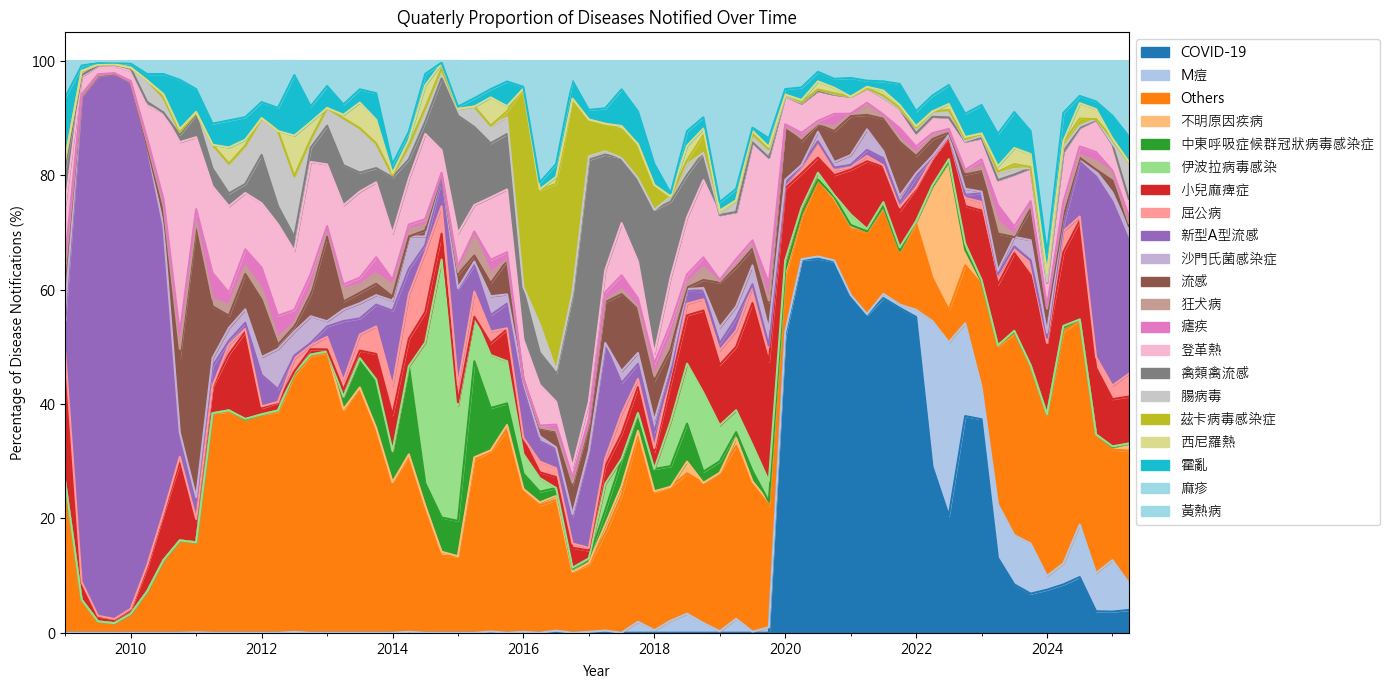

In [309]:
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.family'] = 'Microsoft JhengHei'

plt.rcParams['axes.unicode_minus'] = False

# üü¢ Step 1: Categorize diseases not in list_common_diseases as 'other'
df_plot = df.copy()
df_plot['disease_grouped'] = df_plot['disease_name'].apply(
    lambda x: x if x in list_common_diseases else 'Others'
)

# üü¢ Step 2: Group by month and grouped disease name
df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Q'), 'disease_grouped'])# Y Q M
    .size()
    .reset_index(name='count')
)

# Convert Period to Timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

# üü¢ Step 3: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='disease_grouped', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# üü¢ Step 4: Plot stacked area chart
plt.figure(figsize=(12, 6))
df_percent.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab20')
plt.ylabel('Percentage of Disease Notifications (%)')
plt.title('Quaterly Proportion of Diseases Notified Over Time')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Top 5 disease name heatmap

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_24020\1851928969.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((col, 4 - row), 1, 1, color=color, edgecolor='black'))


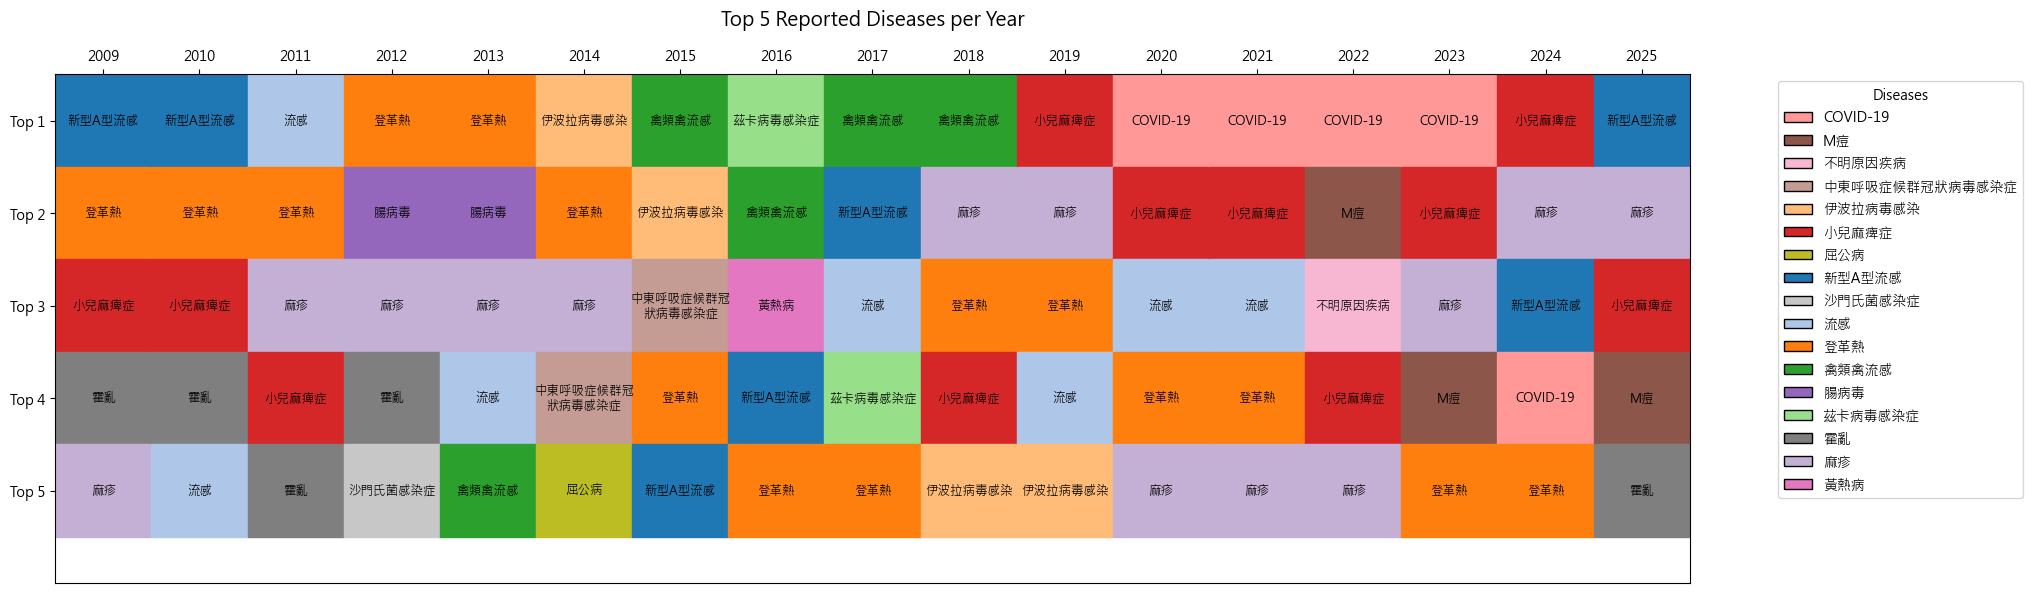

In [310]:
# Top N disease name

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap
# üü¢ Step 1‚Äì4: Same as before
df_plot = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot['year'] = df_plot['date'].dt.year

df_counts = (
    df_plot
    .groupby(['year', 'disease_name'])
    .size()
    .reset_index(name='count')
)

top5_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(5)
)

ranked = (
    top5_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['disease_name']
    .apply(list)
    .reset_index()
)
years = ranked['year'].tolist()
disease_table = pd.DataFrame([r + [None] * (5 - len(r)) for r in ranked['disease_name']], index=years).T

# üü¢ Assign unique color
all_diseases = pd.unique(disease_table.values.ravel())
color_map = dict(zip(all_diseases, plt.cm.tab20.colors[:len(all_diseases)]))

# üü¢ Step 5: Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.2, 6))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, 5)


# Draw cells
for col, year in enumerate(years):
    for row in range(5):
        disease = disease_table.iloc[row, col]
        color = color_map.get(disease, 'lightgray')
        ax.add_patch(plt.Rectangle((col, 4 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(disease, width=8)) if disease else ''
        ax.text(col + 0.5, 4 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# üü¢ Step 6: Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')  # move x-axis label to top
ax.xaxis.tick_top()

# üü¢ Step 6.5: Left Y-axis for "Top 1" to "Top 5"
ax.set_yticks([i + 0.5 for i in range(5)])
ax.set_yticklabels([f"Top {i+1}" for i in range(5)][::-1], fontsize=10)

# üü¢ Step 7: Legend
legend_elements = [
    Patch(facecolor=color_map[d], edgecolor='black', label=d)
    for d in sorted(color_map) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title("Top 5 Reported Diseases per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()



### Report histogram

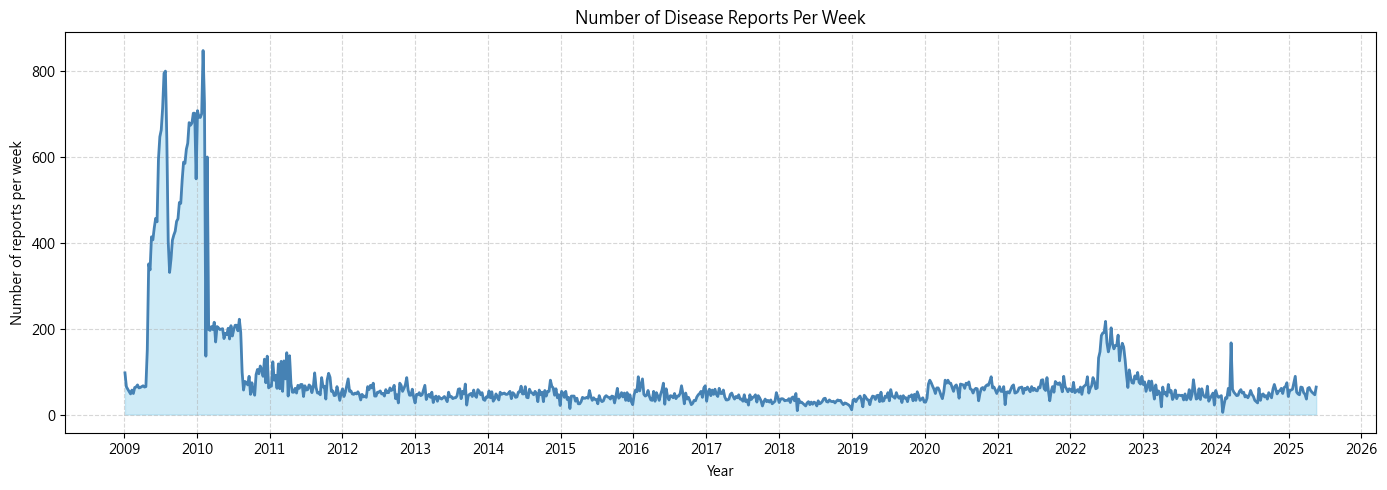

In [311]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# üü¢ Step 1: Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# üü¢ Step 2: Create a new 'week' column that represents the start of each week
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# üü¢ Step 3: Group by week and count number of reports per week
df_weekly_counts = df.groupby('week').size().reset_index(name='count')

# üü¢ Step 4: Plot the weekly report count as a bar chart
plt.figure(figsize=(14, 5))
plt.plot(df_weekly_counts['week'], df_weekly_counts['count'], linestyle='-', color='steelblue', linewidth=2)
plt.fill_between(df_weekly_counts['week'], df_weekly_counts['count'], color='skyblue', alpha=0.4)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)
ax.set_yticks([])

plt.title('Number of Disease Reports Per Week')
plt.xlabel('Year')
plt.ylabel('Number of reports per week')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Bubble plot by disease

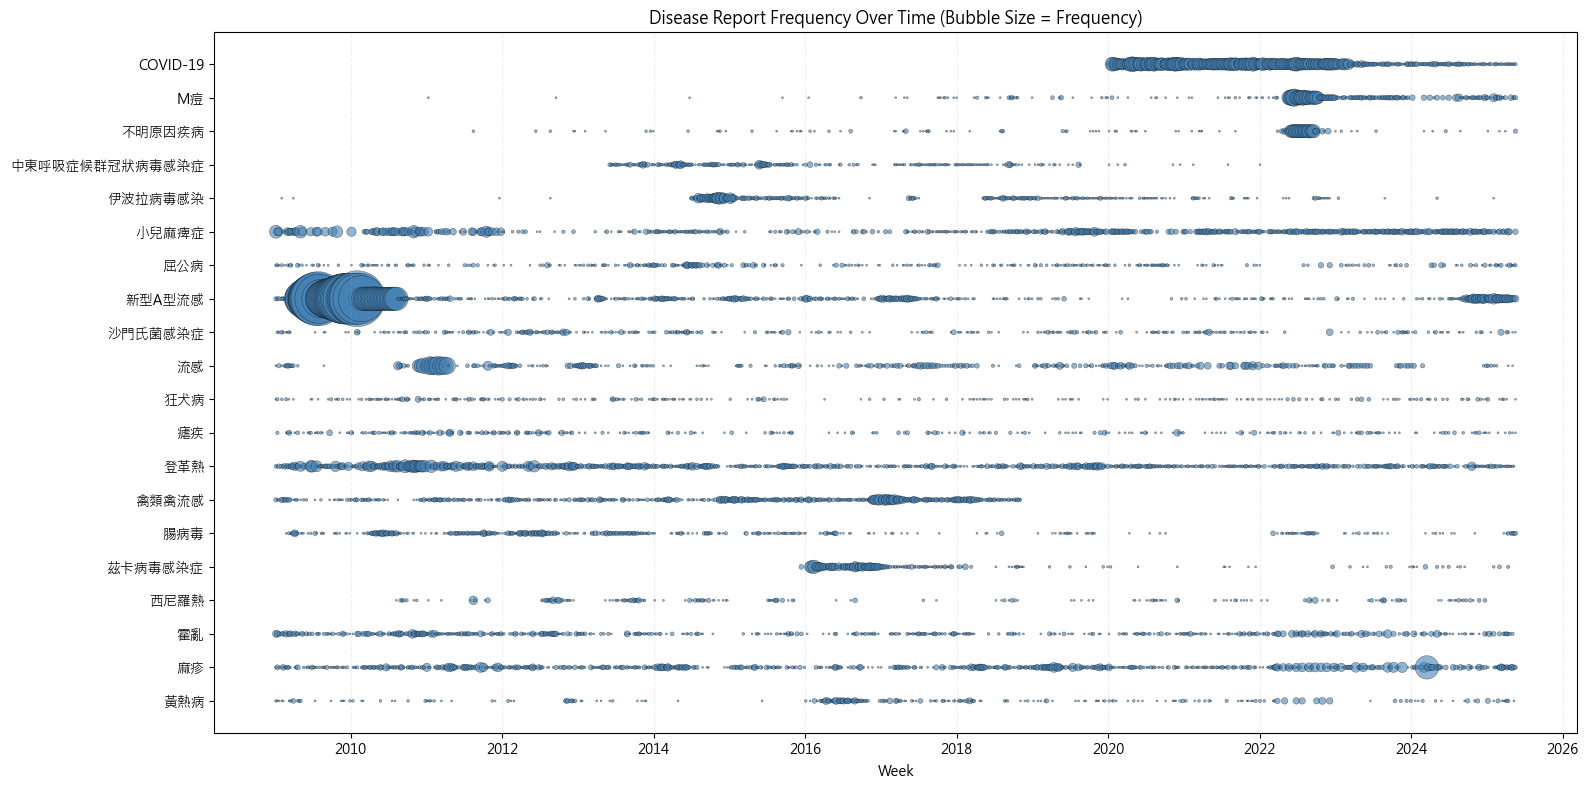

In [312]:
import pandas as pd
import matplotlib.pyplot as plt

# üü¢ Step 1: Prepare data
df_plot = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# üü¢ Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# üü¢ Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# üü¢ Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(16, len(disease_list) * 0.4))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# üü¢ Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show() 


### Bubble plot for PHEIC diseases

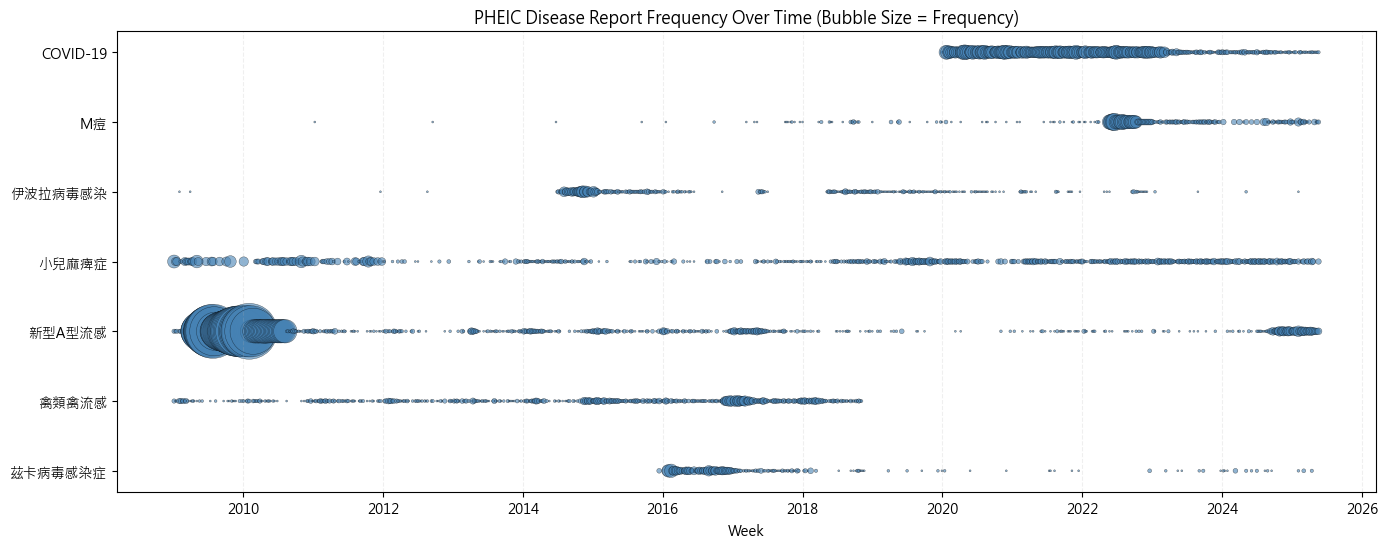

In [313]:
# only PHEIC diseases
import pandas as pd
import matplotlib.pyplot as plt


list_PHEIC_diseases = ["COVID-19","Êñ∞ÂûãAÂûãÊµÅÊÑü","Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü","Â∞èÂÖíÈ∫ªÁó∫Áóá","‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì","MÁóò","Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá"]


df_plot = df[df['disease_name'].isin(list_PHEIC_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# üü¢ Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# üü¢ Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# üü¢ Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(14, len(disease_list) * 0.8))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# üü¢ Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("PHEIC Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()


# Country visualisations

### Top ten countries

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_24020\2206951059.py:55: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))


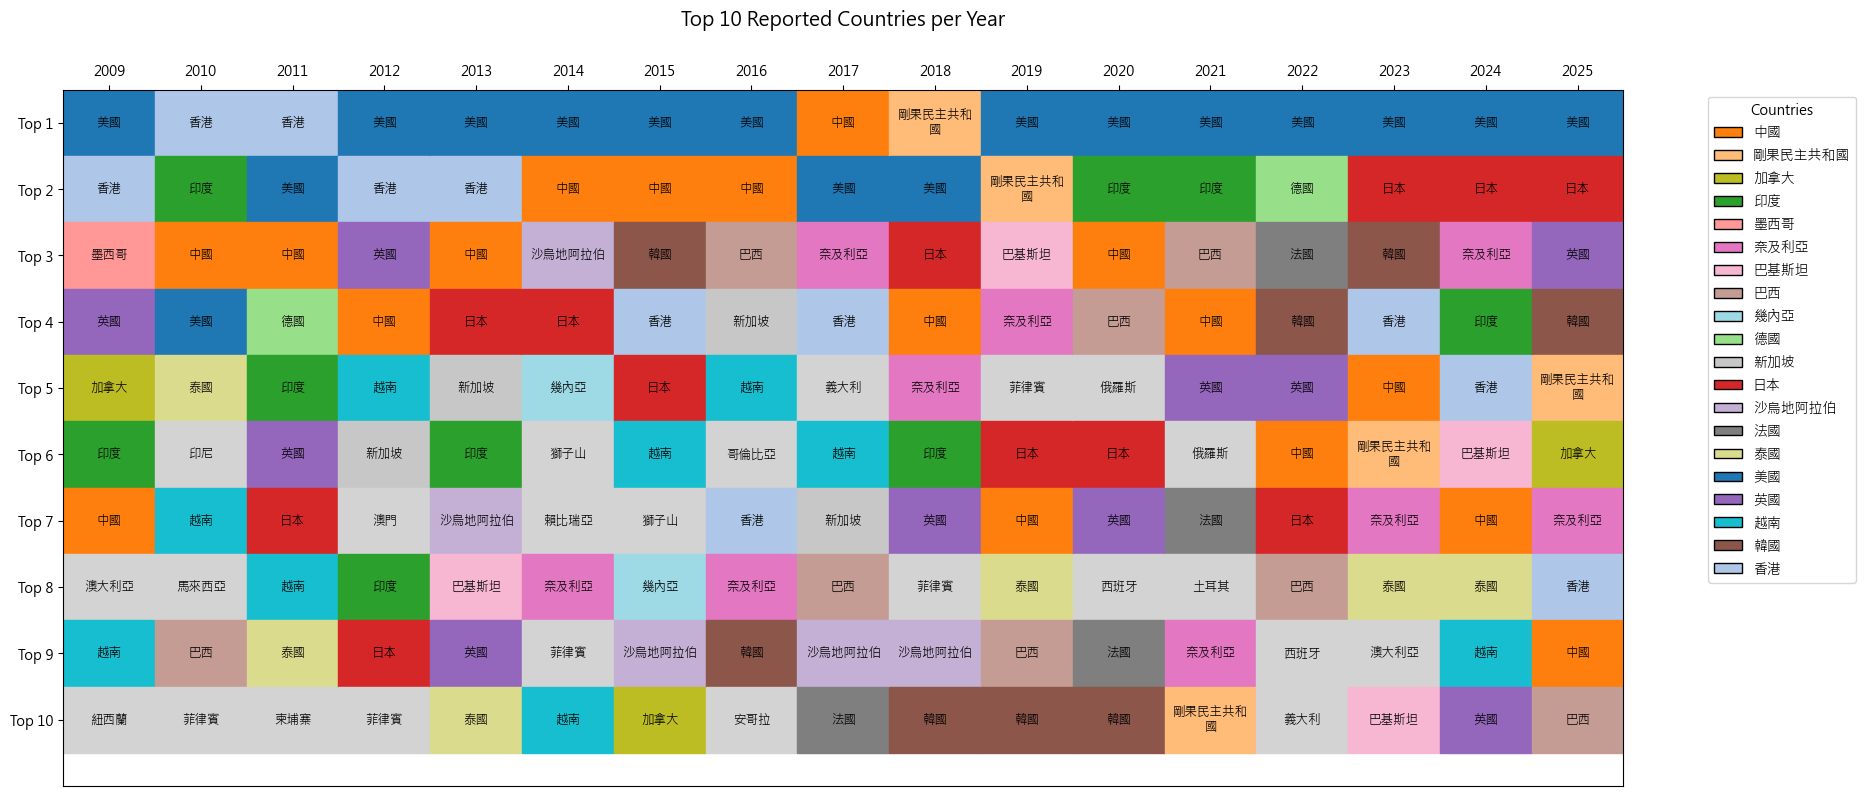

In [314]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap

n_top_countries = 10

# üü¢ Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

df_counts = (
    df_plot
    .groupby(['year', 'country_name_zh'])
    .size()
    .reset_index(name='count')
)

top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# üü¢ Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_name_zh']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_name_zh']],
    index=years
).T

# üü¢ Assign unique colors
all_countries = pd.unique(country_table.values.ravel())
color_map = dict(zip(all_countries, plt.cm.tab20.colors[:len(all_countries)]))

# üü¢ Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country = country_table.iloc[row, col]
        color = color_map.get(country, 'lightgray')
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country, width=6)) if country else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# Legend
legend_elements = [
    Patch(facecolor=color_map[c], edgecolor='black', label=c)
    for c in sorted(color_map) if c is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Countries")

plt.title(f"Top {n_top_countries} Reported Countries per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()

In [315]:
### Top regions

### Top N country_disease

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_24020\821595555.py:74: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))


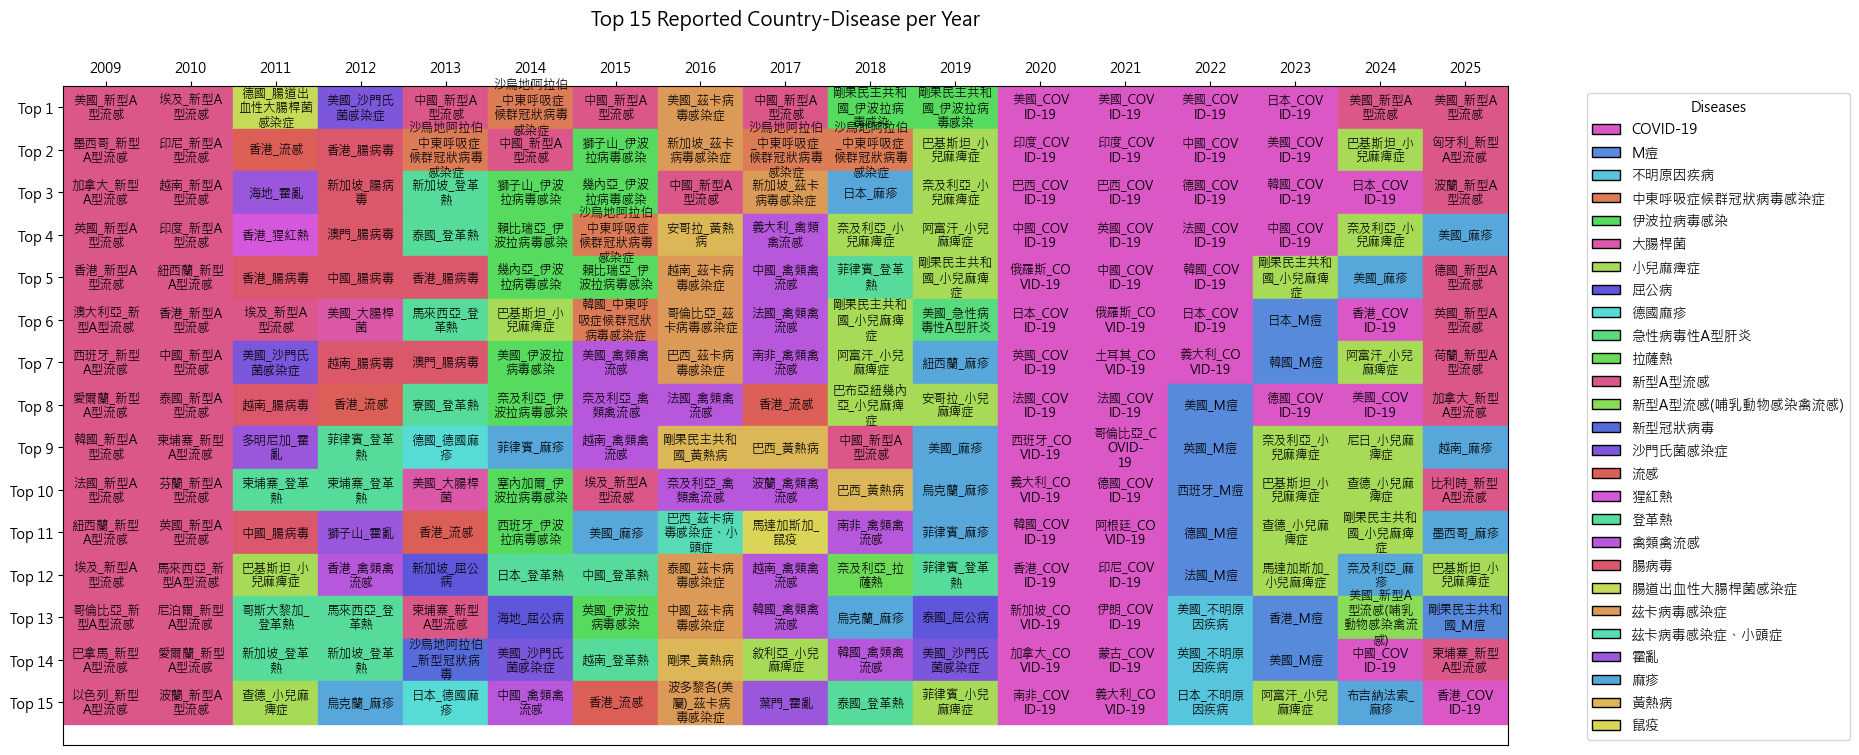

In [326]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
import textwrap

# üü¢ Parameters
n_top_countries = 15

# üü¢ Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

# Group by year and country_disease, count occurrences
df_counts = (
    df_plot
    .groupby(['year', 'country_disease'])
    .size()
    .reset_index(name='count')
)

# Get top N per year
top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_disease']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_disease']],
    index=years
).T

# üü¢ Extract unique disease names from country_disease strings in top N
diseases_in_top = set()
for col in country_table.columns:
    for val in country_table[col]:
        if val:
            disease = val.split('_')[-1]
            diseases_in_top.add(disease)

# Generate color palette for these diseases
palette = sns.color_palette("hls", len(diseases_in_top))
disease_color_map = dict(zip(diseases_in_top, palette))

# üü¢ Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country_disease = country_table.iloc[row, col]
        
        if country_disease:
            # Extract disease_name from country_disease (split by "_")
            disease = country_disease.split('_')[-1]
            color = disease_color_map.get(disease, 'lightgray')
        else:
            color = 'lightgray'
        
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country_disease, width=6)) if country_disease else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# üü¢ Legend showing only disease names
legend_elements = [
    Patch(facecolor=disease_color_map[d], edgecolor='black', label=d)
    for d in sorted(diseases_in_top) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title(f"Top {n_top_countries} Reported Country-Disease per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()


# Variety

### 1. Diversity count (baseline)

In [10]:
variety_count = df.groupby(df['date'].dt.year)['country_disease'].nunique().reset_index()
variety_count.columns = ['year', 'unique_country_disease_count']
print(variety_count)


    year  unique_country_disease_count
0   2009                           798
1   2010                          1020
2   2011                          1105
3   2012                           917
4   2013                           751
5   2014                           646
6   2015                           646
7   2016                           694
8   2017                           605
9   2018                           490
10  2019                           603
11  2020                           554
12  2021                           574
13  2022                           730
14  2023                           764
15  2024                           804
16  2025                           429


## 2. Entropy

    year  shannon_entropy
0   2009             5.34
1   2010             5.83
2   2011             6.41
3   2012             6.21
4   2013             5.93
5   2014             5.48
6   2015             5.69
7   2016             5.75
8   2017             5.52
9   2018             5.52
10  2019             5.70
11  2020             4.94
12  2021             4.99
13  2022             5.16
14  2023             5.99
15  2024             6.14
16  2025             5.63


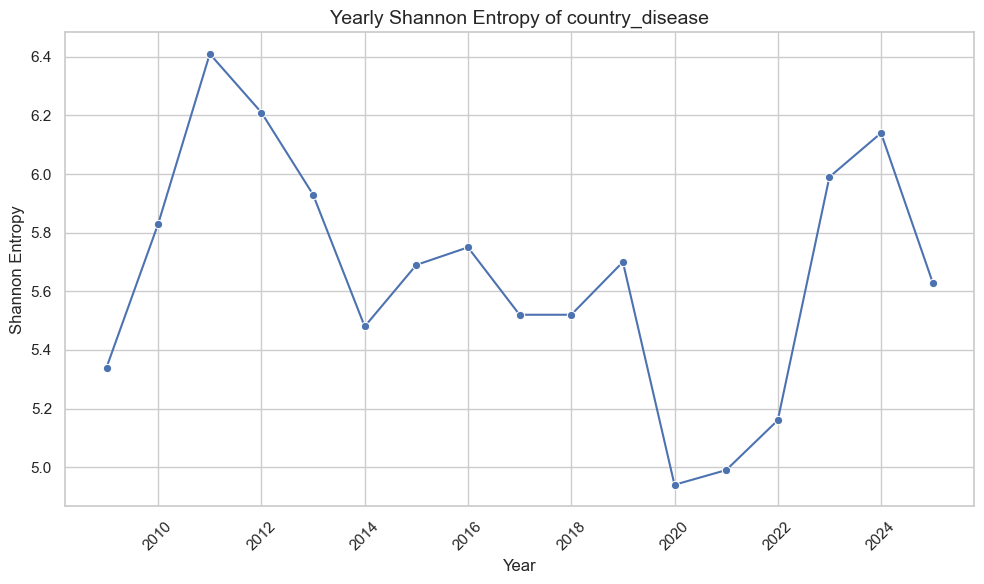

In [ ]:
import numpy as np

def shannon_entropy(x):
    counts = x.value_counts()
    proportions = counts / counts.sum()
    return -np.sum(proportions * np.log(proportions))

entropy = df.groupby(df['date'].dt.year)['country_disease'].apply(shannon_entropy).reset_index().round(2)
entropy.columns = ['year', 'shannon_entropy']
print(entropy)


import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your entropy dataframe is available
# entropy = ... (your existing calculation)

# Set seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10,6))
sns.lineplot(data=entropy, x='year', y='shannon_entropy', marker='o')

# Titles and labels
plt.title('Yearly Entropy of country-disease', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Shannon Entropy', fontsize=12)

# Optional: rotate x-axis labels if many years
plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()